## Setup

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import (
    simple_plot,
    plot_train_val_losses
)
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load data

> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

,datetime,low,high,open,close,volume
timestamp,,,,,,
1422745200,2015-01-31 23:00:00,224.51,225.69,225.38,224.51,29.638700
1422745500,2015-01-31 23:05:00,224.00,225.59,224.62,224.00,52.189176
1422745800,2015-01-31 23:10:00,221.99,223.92,223.91,221.99,40.262566
1422746100,2015-01-31 23:15:00,218.00,222.00,222.00,218.00,163.490760
1422746400,2015-01-31 23:20:00,217.11,218.89,217.92,218.22,96.317898


,datetime,low,high,open,close,volume
timestamp,,,,,,
1539128100,2018-10-09 23:35:00,6590.30,6593.48,6591.54,6590.30,17.148190
1539128400,2018-10-09 23:40:00,6586.55,6590.31,6590.31,6589.30,15.269094
1539128700,2018-10-09 23:45:00,6589.29,6589.69,6589.30,6589.48,12.466310
1539129000,2018-10-09 23:50:00,6589.47,6592.81,6589.48,6591.85,14.972801
1539129300,2018-10-09 23:55:00,6589.47,6592.81,6591.84,6589.48,31.305392


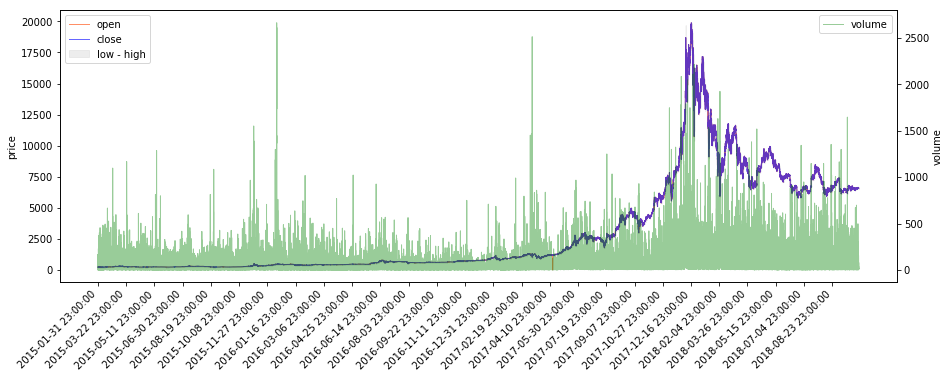

In [3]:
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'

data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

## Base model (from prev version)

data ~ (28000, 1)
--- 0.016s to model compilation time


--- Created model id: 139910002009360
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
__________________________________________________

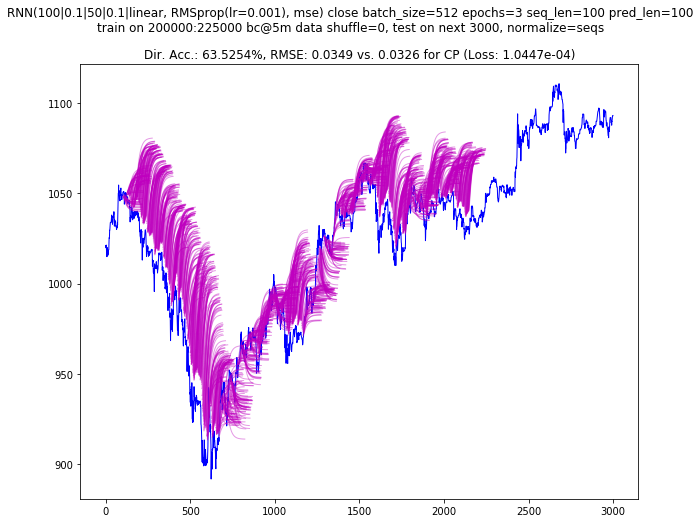

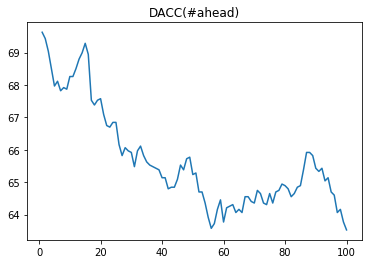

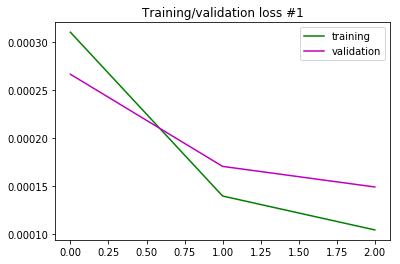

--- 378.878s to run experiment



In [3]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=[
            'close',
        ],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            lr=1e-3,
            optimizer=keras.optimizers.RMSprop
        ),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (28000, 1)
--- 0.015s to model compilation time


--- Created model id: 139907095635216
Tensor("lstm_3_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
__________________________________________________

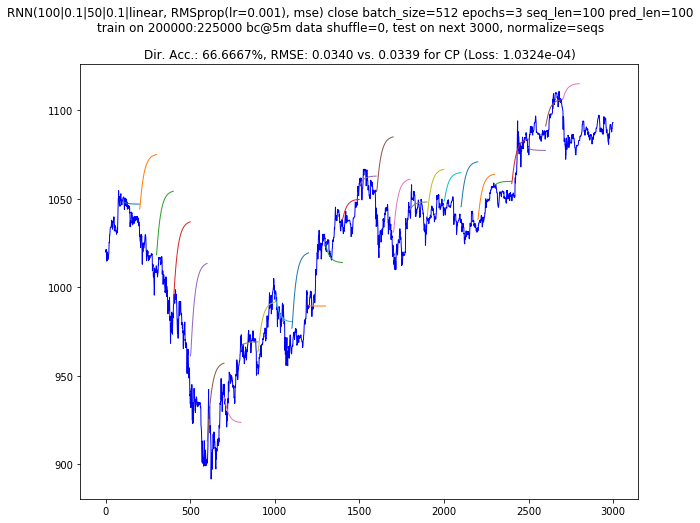

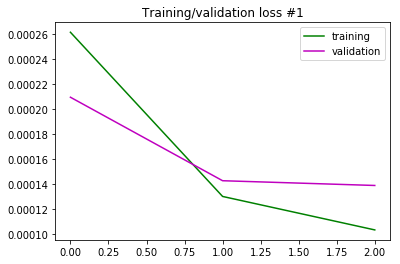

--- 134.510s to run experiment



In [4]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=[
            'close',
        ],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            lr=1e-3,
            optimizer=keras.optimizers.RMSprop
        ),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (28000, 1)
--- 0.014s to model compilation time


--- Created model id: 139907986282128
Tensor("lstm_5_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
__________________________________________________

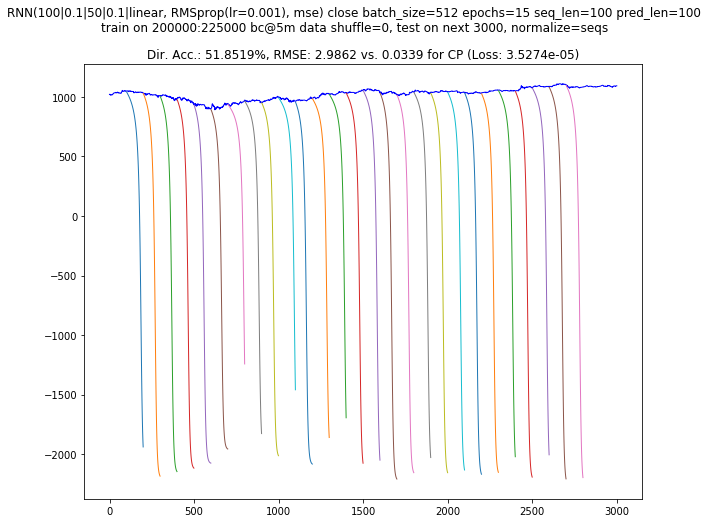

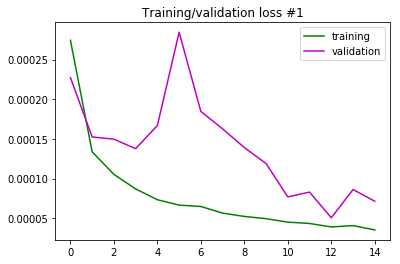

--- 673.680s to run experiment



In [5]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=[
            'close',
        ],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            lr=1e-3,
            optimizer=keras.optimizers.RMSprop
        ),
        # training:
        epochs=15,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (28000, 1)
--- 0.015s to model compilation time


--- Created model id: 139909761420688
Tensor("lstm_7_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
__________________________________________________

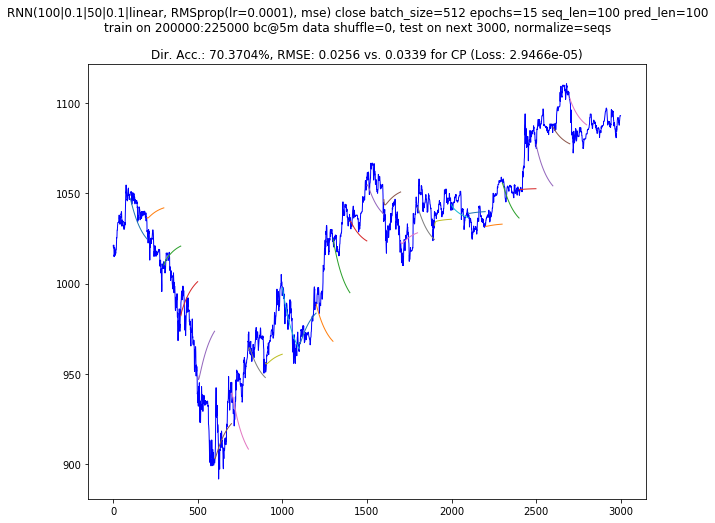

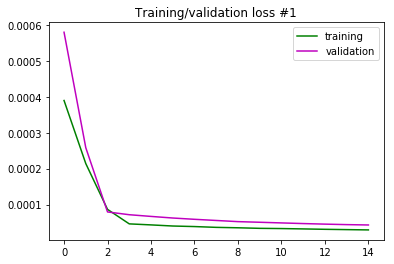

--- 549.713s to run experiment



In [6]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=[
            'close',
        ],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            lr=1e-4,
            optimizer=keras.optimizers.RMSprop
        ),
        # training:
        epochs=15,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (28000, 1)
--- 0.018s to model compilation time


--- Created model id: 139909701207248
Tensor("lstm_9_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
__________________________________________________

Epoch 3/8
22409/22409 [==============================] - 40s 2ms/step - loss: 6.4167e-05 - val_loss: 9.0689e-05
Epoch 4/8
22409/22409 [==============================] - 35s 2ms/step - loss: 5.1503e-05 - val_loss: 8.2354e-05
Epoch 5/8
22409/22409 [==============================] - 33s 1ms/step - loss: 4.7870e-05 - val_loss: 7.5086e-05
Epoch 6/8
22409/22409 [==============================] - 37s 2ms/step - loss: 4.4034e-05 - val_loss: 6.7266e-05
Epoch 7/8
22409/22409 [==============================] - 35s 2ms/step - loss: 4.0637e-05 - val_loss: 6.2340e-05
Epoch 8/8
22409/22409 [==============================] - 40s 2ms/step - loss: 3.8827e-05 - val_loss: 6.0094e-05
--- 298.346s to train model

--- 3.823s to walk and predict

--- 0.054s to plot incremental predictions



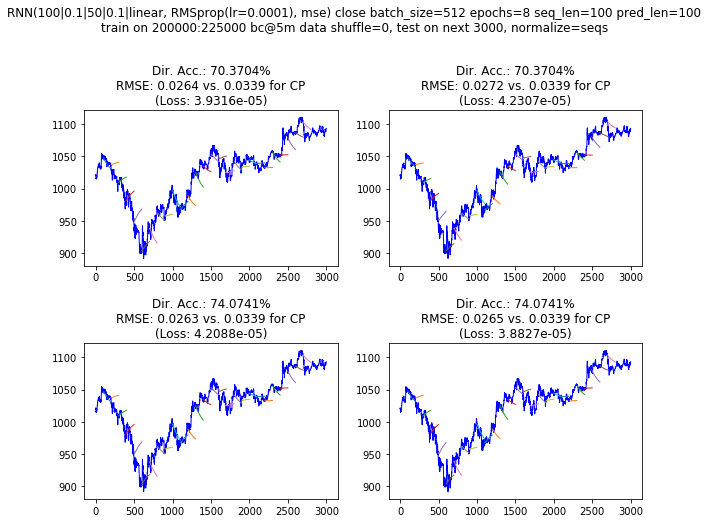

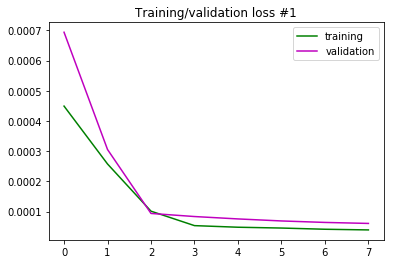

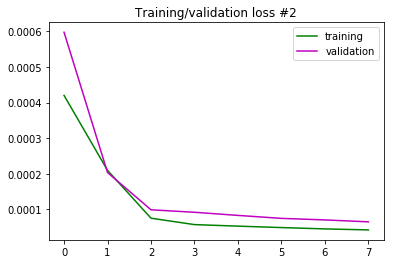

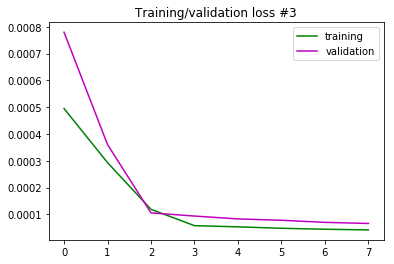

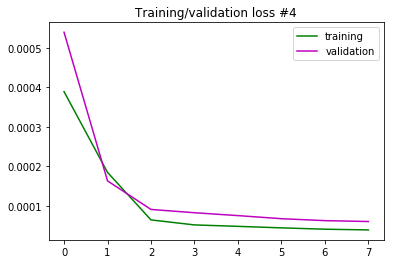

--- 1169.557s to run experiment



In [7]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=[
            'close',
        ],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            lr=1e-4,
            optimizer=keras.optimizers.RMSprop
        ),
        # training:
        epochs=8,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

### ARIMA for reference

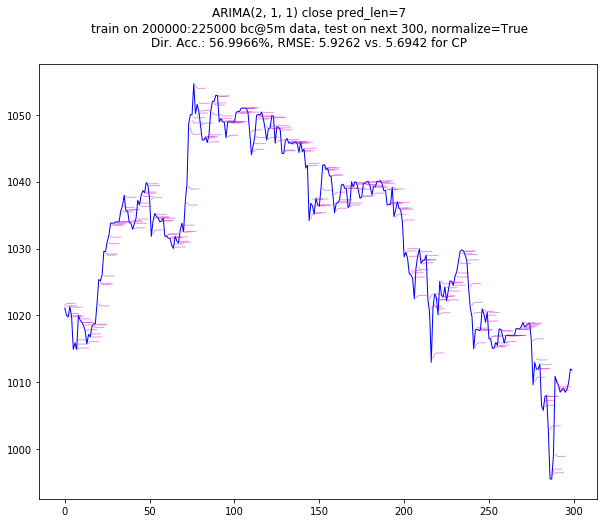

In [6]:
run_walk_forward_validation_arima(
    # data to extract:
    data5m,
    features=['close'],
    from_i=200000,
    train_sz=25000,
    test_sz=300,
    # data processing:
    normalize=True,
    order=(2, 1, 1),
    pred_len=7,
    skip=False,
    fix_all_rngs_to=False,
    fix_rngs_before_each=False,
)